In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import *
import time
from datetime import datetime
import os
from torch.utils import data
import random
import copy
import itertools
import io
import uuid
from sklearn.model_selection import KFold, train_test_split
import itertools
import warnings
warnings.filterwarnings('ignore')

import wandb
wandb_username = 'denizjafari'
local_username = 'denizjafari'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1') 
else:
    device = torch.device('cpu')
print(device)

cuda:1


In [3]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"
split_file_base = "/home/andreasabo/Documents/HNUltra/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/" + local_username + "/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_1000000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'image_ids', 'view_label', 'view_train'])

# Are we doing the final test?
test_data = True

### **Reading Data Indicies and Labels**

In [4]:
label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 
                 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
label_unmapping = {0: 'Other', 1:'Saggital_Right', 2: 'Transverse_Right', 
                   3:'Saggital_Left', 4:'Transverse_Left', 5: 'Bladder'}

data_df['view_label'] = data_df['view_label'].map(label_mapping)

train_df = data_df[data_df.view_train == 1]
test_df = data_df[data_df.view_train == 0]

unique_subj = train_df.subj_id.unique()

# Create the splits for 5-fold cross validation based on subj_id
data_split_file = split_file_base + 'data_splits.json'
# just load from file
print("Reading splits from file")
with open(data_split_file, 'r') as f:
    all_folds = json.load(f)

# If we're testing, overwrite the training data with the entire train/test data
if test_data:
    train_images = train_df.image_ids.tolist()
    test_images = test_df.image_ids.tolist()
    train_labels = train_df.view_label.tolist()
    test_labels = test_df.view_label.tolist()

    cur_fold = {'train_ids': train_images, 'test_ids': test_images, 'train_labels': train_labels, 'test_labels': test_labels}

    
    all_folds['test'] = cur_fold

Reading splits from file


In [5]:
print(len(all_folds['test']['train_ids']))
print(len(all_folds['0']['train_ids']))

print(len(all_folds['test']['test_ids']))
print(len(all_folds['0']['valid_ids']))

13958
11081
5070
2877


In [6]:
# MODEL DIRECTORIES 


vae50_dir = '/home/navidkorhani/Documents/HNProject/HNUltra/saved models/vae_model_h800_l50.pt'
vae100_dir = "/home/navidkorhani/Documents/HNProject/HNUltra/results/h800_l100_e30/vae_model.pt"
vae200_dir = "/home/navidkorhani/Documents/HNProject/HNUltra/results/h800_l200_e30/vae_model.pt"


In [7]:
# source: https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm,rep, classnames, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classnames))
    plt.xticks(tick_marks, classnames, rotation=45)
    plt.yticks(tick_marks, classnames)
    
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('ViewNetConfMtrx' + str(rep) + '.png')

# Models Initialization 

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == 'vae50':
        
        model_ft = VAE_50()
        input_size = 256
        
    elif model_name == 'vae100':
        
        model_ft = VAE_100()
        input_size = 256
        
    elif model_name == 'vae200':
        
        model_ft = VAE_200()
        input_size = 256
        
        
    elif model_name == 'viewnet':
        conv1_filters = 8
        conv2_filters = 16
        conv3_filters = 32
        linear1_size = 512
        dropout = 0.25
        model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
        input_size = 256
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size




# Models Architectures 

In [10]:
# custom view labeller 
class ViewNet(nn.Module):

    def __init__(self, num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout):
        super(ViewNet, self).__init__()
        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.conv3_filters = conv3_filters
        self.linear1_size = linear1_size
        self.drop_percent = dropout
        self.max_pool = 4
        self.conv_output = int(self.conv3_filters*(256/(self.max_pool**3))*(256/(self.max_pool**3)))
        print("conv_output: ", self.conv_output)

        
        self.conv1 = nn.Conv2d(1, self.conv1_filters, 4, padding=2)
        self.conv2 = nn.Conv2d(self.conv1_filters, self.conv2_filters, 4, padding=2)
        self.conv3 = nn.Conv2d(self.conv2_filters, self.conv3_filters, 4, padding=2)
        self.pool = nn.MaxPool2d(self.max_pool, self.max_pool)
        self.dropout = nn.Dropout(self.drop_percent)
        self.linear1 = nn.Linear(self.conv_output, self.linear1_size)
        self.linear2 = nn.Linear(self.linear1_size, num_classes)
    
    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = self.pool(self.dropout(F.relu(self.conv3(x))))
        x = x.view(-1, self.conv_output) 
        x = self.dropout(F.relu((self.linear1(x))))
        x = self.linear2(x)
        return x
    
    
class VAE_50(nn.Module):
    def __init__(self):
        super(VAE_50, self).__init__()
        
        hidden_dim = 800
        latent_dim = 50
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    
class VAE_100(nn.Module):
    def __init__(self):
        super(VAE_100, self).__init__()
        
        hidden_dim = 800
        latent_dim = 100
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class VAE_200(nn.Module):
    def __init__(self):
        super(VAE_200, self).__init__()
        
        hidden_dim = 800
        latent_dim = 200
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [11]:
# Code from: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=True):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

# Model Training 

In [12]:
def train5fold(network_configs,criterion_used,  model_ft, lr, wd, amsgrad, repetitions):
    fold = 'test'

    random_str = str(uuid.uuid4()).split("-")[0]
    best_metrics_per_fold = []
    final_df = pd.DataFrame()
    model_base = copy.deepcopy(model_ft)
    
    for i in range(repetitions):
        now = datetime.now()
        date_time = now.strftime("%d-%m-%Y.%H:%M:%S")
        wandb.init(project='hnultra_test', entity=wandb_username, name=local_username + '_rep_' + i, group=random_str)
        partition = all_folds[fold]

        model_ft = copy.deepcopy(model_base)
        model_ft = model_ft.to(device)
        wandb.watch(model_ft)

        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = model_ft.parameters()
        #print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t",name)
        else:
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd, amsgrad=amsgrad)

        # Setup the loss fxn
        criterion = criterion_used

        shuffle = True
        num_workers = 0
        params = {'batch_size': batch_size,
                  'shuffle': shuffle,
                  'num_workers': num_workers}

        config_dict = {'i': i, 'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'fold': fold,
                       'lr': lr, 'wd': wd, 'amsgrad': amsgrad, 'model_name': model_name,'criterion': criterion, 'num_classes': num_classes, 
                       'num_epochs': num_epochs, 'feature_extract': feature_extract, "pretrain": pretrain }

        wandb.config.update(config_dict)
        wandb.config.update(network_configs)
        # Tranforms
        trans = transforms.Compose([transforms.RandomAffine(degrees=8, translate=(0.1, 0.1), scale=(0.95,1.25))])

        # Generators
        training_set = Dataset(partition['train_ids'], partition['train_labels'], transformations=trans)
        training_generator = data.DataLoader(training_set, **params)

        validation_set = Dataset(partition['test_ids'], partition['test_labels'])
        validation_generator = data.DataLoader(validation_set, **params)

        dataloaders_dict = {'train':training_generator, 'test':validation_generator}

        # Train & Evaluate
        model_ft, metrics_from_best_epoch, rep_ids, rep_labels, rep_preds = train_model(model_ft, 
                    dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))
        best_metrics_per_fold.append(metrics_from_best_epoch)
        final_df['IDs_iter_' + str(i)] = rep_ids
        final_df['labels_iter_' + str(i)] = rep_labels
        final_df['preds_iter_' + str(i)] = rep_preds
       

    # Calculate the performance metrics on the best model in each fold
    wandb.init(project='hnultra', entity=wandb_username, name=local_username + '_ALL', group=random_str)
    config_dict['fold'] = -1
    wandb.config.update(config_dict)
    wandb.config.update(network_configs)


    metrics_all = {}
    for fold in best_metrics_per_fold:
        for key in fold:
            if key not in metrics_all:
                metrics_all[key] = [fold[key]]
            else:
                metrics_all[key].append(fold[key]) 

    metrics_to_log = {}
    for m in metrics_all:
        metric_list = np.asarray(metrics_all[m])

        metrics_to_log[m + '_mean'] = metric_list.mean()    
        metrics_to_log[m + '_stdev'] = metric_list.std()

    wandb.config.update(metrics_to_log)
    return final_df
  

In [13]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transformations=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transformations = transformations
        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path).convert('L')
        
        if self.transformations:
            image = self.transformations(image)
        
        image = ToTensor()(image)
        
        y = torch.FloatTensor([0]*6)        
        y[int(self.labels[index])] = 1

        return image, y, ID

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, final_testing=True):
    es = EarlyStopping(patience = 15)
    stop_now = 0

    since = time.time()
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    #val_acc_history = []
    
    #val_metrics_list = []
    #train_metrics_list = []
    y_test_last = []
    y_pred_last = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_with_best_val_acc = num_epochs -1
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 54)

        if stop_now:
            break
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []

            # save the needed data 
            new_col_ids = []
            #new_col_labels = []
            #new_col_preds = []
            
            # Iterate over data.
            for inputs, labels, ids in dataloaders[phase]:
                labels = labels.type(torch.long)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if epoch == (num_epochs -1):
                    new_col_ids += ids.tolist()
                    
                    
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        labels = torch.argmax(labels, 1)
                        running_preds += torch.argmax(outputs, 1).tolist()
                        running_labels += labels.tolist()
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))

            if phase == 'train':
                wandb.log({'epoch': epoch, 'train_acc':epoch_acc, 'train_loss':epoch_loss})
                
                cur_train_metrics = {}
                                # compute and log f1, precision, recall for each class
                for c in range(6):
                    running_labels = np.asarray(running_labels)
                    running_preds = np.asarray(running_preds)

                    cur_c_labs_bin = np.asarray([0] *len(running_labels))
                    cur_c_preds_bin = np.asarray([0] *len(running_labels))

                    # Need to binarize
                    cur_c_preds_bin[running_preds == c] = 1
                    cur_c_labs_bin[running_labels == c] = 1
                    f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                    precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                    recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)
                    
                    cur_train_metrics['train_' + label_unmapping[c] + '_f1'] = f1
                    cur_train_metrics['train_' + label_unmapping[c] + '_precision'] = precision
                    cur_train_metrics['train_' + label_unmapping[c] + '_recall'] = recall
                    
                
                #train_metrics_list.append(cur_train_metrics)
                
                average_types = ['macro', 'micro', 'weighted']
                average_metrics_to_log = ['precision', 'recall', 'f1score', 'support']
                average_dict = {'epoch': epoch}
                for av in average_types:
                    results_tuple = precision_recall_fscore_support(running_labels, running_preds, average=av)
                    for m in range(len(average_metrics_to_log)):      
                        average_dict[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                        cur_train_metrics[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                cur_train_metrics[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)                  
                average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
                wandb.log(cur_train_metrics)
                
            if phase == 'test':
                wandb.log({'test_loss':epoch_loss, 'test_acc':epoch_acc, 'epoch': epoch})
                if epoch == (num_epochs-1):
            
                    cur_val_metrics = {}
                    # compute and log f1, precision, recall for each class
                    for c in range(6):
                        running_labels = np.asarray(running_labels)
                        running_preds = np.asarray(running_preds)
                        new_col_ids = np.asarray(new_col_ids)
                        # confusion matrix of the last epoch
                        conf_mx = confusion_matrix(running_labels, running_preds)

                        cur_c_labs_bin = np.asarray([0] *len(running_labels))
                        cur_c_preds_bin = np.asarray([0] *len(running_labels))

                        # Need to binarize
                        cur_c_preds_bin[running_preds == c] = 1
                        cur_c_labs_bin[running_labels == c] = 1
                        f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                        precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                        recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)

                        wandb.log({'test_' + label_unmapping[c] + '_f1': f1})
                        wandb.log({'test_' + label_unmapping[c] + '_precision': precision})
                        wandb.log({'test_' + label_unmapping[c] + '_recall': recall})
                        #wandb.log({'test_' + '_confusion_matrix': conf_mx})

                        cur_val_metrics['val_' + label_unmapping[c] + '_f1'] = f1
                        cur_val_metrics['val_' + label_unmapping[c] + '_precision'] = precision
                        cur_val_metrics['val_' + label_unmapping[c] + '_recall'] = recall

                    average_types = ['macro', 'micro', 'weighted']
                    average_metrics_to_log = ['precision', 'recall', 'f1score']
                    average_dict = {'epoch': epoch}
                    for av in average_types:
                        results_tuple = precision_recall_fscore_support(running_labels, running_preds, average=av)
                        for m in range(len(average_metrics_to_log)):      
                            average_dict[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                            cur_val_metrics[phase + '_'+ average_metrics_to_log[m] +'_average_' + av] = results_tuple[m]
                    cur_val_metrics[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)                  
                    average_dict[phase + '_acc_average'] = accuracy_score(running_labels, running_preds)     
                    print(cur_val_metrics)
                    wandb.log(cur_val_metrics)


                    #val_metrics_list.append(cur_val_metrics)
                
            if phase == 'train':
                print(classification_report(running_labels, running_preds))
                train_acc = epoch_acc
                if epoch == (num_epochs-1):
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), os.path.join(wandb.run.dir, "ViewNetFinalTrainModel.pt"))
                
            if phase == 'test' and epoch == (num_epochs-1):
                best_acc = epoch_acc
                best_acc_train = train_acc
                print(classification_report(running_labels, running_preds))
                print()
                #print(conf_mx)
                plot_confusion_matrix(conf_mx,classnames, title='Test Data Confusion matrix - ViewNet', 
                                      cmap=plt.cm.Blues)
                
           # if phase == 'test' and epoch_acc > best_acc:
            #    best_acc = epoch_acc
            #    best_acc_train = train_acc
            #    epoch_with_best_val_acc = epoch
            #    best_model_wts = copy.deepcopy(model.state_dict())
            #    torch.save(model.state_dict(), os.path.join(wandb.run.dir, "model.pt"))
            #    print(classification_report(running_labels, running_preds))

            #if phase == 'test':
            #    val_acc_history.append(epoch_acc)
            #    if es.step(epoch_loss) and not final_testing:
            #        stop_now = 1
            #        print("EARLY STOPPING " + str(epoch))
            #        break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}\n'.format(best_acc))
    
    # Directly save the best results in this fold
    wandb.config.best_acc = best_acc
    wandb.config.best_epoch = epoch_with_best_val_acc

    #wandb.config.val_acc_history = val_acc_history
    wandb.config.best_epoch = epoch_with_best_val_acc
    
    #wandb.config.update(val_metrics_list[epoch_with_best_val_acc])
    wandb.config.update(cur_val_metrics)
    #wandb.config.update(train_metrics_list[epoch_with_best_val_acc])
    wandb.config.update(cur_train_metrics)
    
    metrics_from_best_epoch = {'best_epoch': epoch_with_best_val_acc, 'last_epoch': epoch}
    metrics_from_best_epoch.update( cur_val_metrics )
    #metrics_from_best_epoch.update( train_metrics_list[epoch_with_best_val_acc] )
    metrics_from_best_epoch.update(cur_train_metrics)
    metrics_from_best_epoch.update( {'val_acc': best_acc.cpu(), 'train_acc': best_acc_train.cpu()} )    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    #return model, val_acc_history, metrics_from_best_epoch
    return model, metrics_from_best_epoch, new_col_ids, running_labels, running_preds
    

In [14]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, viewnet]
model_name = "viewnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 100

# Number of epochs to train for
num_epochs = 46

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = False

# Flag for whether or not to use pretrained model
pretrain = False

criterion_used = nn.CrossEntropyLoss()

conv_output:  512


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/46
------------------------------------------------------
train loss:	1.6010 | train acc:	0.3667

              precision    recall  f1-score   support

           0       0.37      0.93      0.53      4943
           1       0.27      0.03      0.05      2225
           2       0.16      0.01      0.02      1539
           3       0.32      0.08      0.13      2284
           4       0.00      0.00      0.00      1669
           5       0.56      0.18      0.28      1298

    accuracy                           0.37     13958
   macro avg       0.28      0.21      0.17     13958
weighted avg       0.29      0.37      0.24     13958

test loss:	1.5514 | test acc:	0.4337

Epoch 2/46
------------------------------------------------------
train loss:	1.4237 | train acc:	0.4363

              precision    recall  f1-score   support

    

test loss:	1.2847 | test acc:	0.5404

Epoch 13/46
------------------------------------------------------
train loss:	1.1144 | train acc:	0.5685

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      4943
           1       0.61      0.47      0.54      2225
           2       0.55      0.32      0.40      1539
           3       0.50      0.50      0.50      2284
           4       0.49      0.37      0.42      1669
           5       0.75      0.75      0.75      1298

    accuracy                           0.57     13958
   macro avg       0.58      0.53      0.54     13958
weighted avg       0.57      0.57      0.56     13958

test loss:	1.2511 | test acc:	0.5576

Epoch 14/46
------------------------------------------------------
train loss:	1.1081 | train acc:	0.5667

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      4943
           1       0.60      0.45      0.51      2225
    

test loss:	1.2161 | test acc:	0.5795

Epoch 25/46
------------------------------------------------------
train loss:	0.9982 | train acc:	0.6167

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      4943
           1       0.67      0.51      0.58      2225
           2       0.62      0.42      0.50      1539
           3       0.56      0.56      0.56      2284
           4       0.56      0.46      0.51      1669
           5       0.80      0.80      0.80      1298

    accuracy                           0.62     13958
   macro avg       0.63      0.59      0.60     13958
weighted avg       0.62      0.62      0.61     13958

test loss:	1.1492 | test acc:	0.5917

Epoch 26/46
------------------------------------------------------
train loss:	0.9750 | train acc:	0.6252

              precision    recall  f1-score   support

           0       0.61      0.74      0.67      4943
           1       0.65      0.52      0.58      2225
    

test loss:	1.1153 | test acc:	0.6034

Epoch 37/46
------------------------------------------------------
train loss:	0.8900 | train acc:	0.6620

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      4943
           1       0.71      0.55      0.62      2225
           2       0.67      0.53      0.60      1539
           3       0.61      0.62      0.61      2284
           4       0.61      0.54      0.57      1669
           5       0.82      0.83      0.83      1298

    accuracy                           0.66     13958
   macro avg       0.68      0.64      0.65     13958
weighted avg       0.66      0.66      0.66     13958

test loss:	1.0958 | test acc:	0.5915

Epoch 38/46
------------------------------------------------------
train loss:	0.8980 | train acc:	0.6599

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      4943
           1       0.71      0.58      0.64      2225
    

wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py


test loss:	1.1100 | test acc:	0.5963

{'val_Other_f1': 0.6334212419084153, 'val_Other_precision': 0.605685465382852, 'val_Other_recall': 0.6638190954773869, 'val_Saggital_Right_f1': 0.5407788390889052, 'val_Saggital_Right_precision': 0.6444833625218914, 'val_Saggital_Right_recall': 0.46582278481012657, 'val_Transverse_Right_f1': 0.5833333333333334, 'val_Transverse_Right_precision': 0.735, 'val_Transverse_Right_recall': 0.48355263157894735, 'val_Saggital_Left_f1': 0.47706422018348627, 'val_Saggital_Left_precision': 0.4323040380047506, 'val_Saggital_Left_recall': 0.5321637426900585, 'val_Transverse_Left_f1': 0.4990892531876139, 'val_Transverse_Left_precision': 0.4798598949211909, 'val_Transverse_Left_recall': 0.5199240986717267, 'val_Bladder_f1': 0.8237704918032787, 'val_Bladder_precision': 0.7960396039603961, 'val_Bladder_recall': 0.8535031847133758, 'test_precision_average_macro': 0.6155620607985135, 'test_recall_average_macro': 0.5864642563236037, 'test_f1score_average_macro': 0.59290

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/46
------------------------------------------------------
train loss:	1.6244 | train acc:	0.3617

              precision    recall  f1-score   support

           0       0.36      0.97      0.53      4943
           1       0.29      0.01      0.03      2225
           2       0.07      0.00      0.01      1539
           3       0.35      0.03      0.06      2284
           4       0.00      0.00      0.00      1669
           5       0.59      0.11      0.19      1298

    accuracy                           0.36     13958
   macro avg       0.28      0.19      0.14     13958
weighted avg       0.29      0.36      0.22     13958

test loss:	1.5880 | test acc:	0.4057

Epoch 2/46
------------------------------------------------------
train loss:	1.4388 | train acc:	0.4299

              precision    recall  f1-score   support

    

test loss:	1.2705 | test acc:	0.5469

Epoch 13/46
------------------------------------------------------
train loss:	1.1277 | train acc:	0.5637

              precision    recall  f1-score   support

           0       0.56      0.74      0.63      4943
           1       0.60      0.45      0.51      2225
           2       0.55      0.31      0.40      1539
           3       0.49      0.50      0.49      2284
           4       0.49      0.36      0.42      1669
           5       0.76      0.77      0.76      1298

    accuracy                           0.56     13958
   macro avg       0.58      0.52      0.54     13958
weighted avg       0.56      0.56      0.55     13958

test loss:	1.2541 | test acc:	0.5629

Epoch 14/46
------------------------------------------------------
train loss:	1.1114 | train acc:	0.5726

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      4943
           1       0.62      0.47      0.53      2225
    

test loss:	1.1675 | test acc:	0.5949

Epoch 25/46
------------------------------------------------------
train loss:	1.0001 | train acc:	0.6195

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      4943
           1       0.68      0.51      0.58      2225
           2       0.61      0.44      0.51      1539
           3       0.54      0.56      0.55      2284
           4       0.57      0.49      0.53      1669
           5       0.80      0.80      0.80      1298

    accuracy                           0.62     13958
   macro avg       0.64      0.59      0.61     13958
weighted avg       0.62      0.62      0.61     13958

test loss:	1.1989 | test acc:	0.5888

Epoch 26/46
------------------------------------------------------
train loss:	0.9907 | train acc:	0.6206

              precision    recall  f1-score   support

           0       0.60      0.76      0.67      4943
           1       0.68      0.51      0.58      2225
    

test loss:	1.1188 | test acc:	0.6034

Epoch 37/46
------------------------------------------------------
train loss:	0.9109 | train acc:	0.6542

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      4943
           1       0.68      0.54      0.60      2225
           2       0.66      0.51      0.58      1539
           3       0.60      0.62      0.61      2284
           4       0.61      0.53      0.57      1669
           5       0.82      0.83      0.82      1298

    accuracy                           0.65     13958
   macro avg       0.67      0.63      0.65     13958
weighted avg       0.66      0.65      0.65     13958

test loss:	1.1244 | test acc:	0.6043

Epoch 38/46
------------------------------------------------------
train loss:	0.8887 | train acc:	0.6619

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      4943
           1       0.71      0.57      0.63      2225
    

wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py


test loss:	1.1033 | test acc:	0.6087

{'val_Other_f1': 0.6500576701268741, 'val_Other_precision': 0.6008528784648187, 'val_Other_recall': 0.7080402010050251, 'val_Saggital_Right_f1': 0.5636232925952552, 'val_Saggital_Right_precision': 0.6522462562396006, 'val_Saggital_Right_recall': 0.4962025316455696, 'val_Transverse_Right_f1': 0.5946935041171089, 'val_Transverse_Right_precision': 0.6701030927835051, 'val_Transverse_Right_recall': 0.5345394736842105, 'val_Saggital_Left_f1': 0.4565537555228277, 'val_Saggital_Left_precision': 0.4599406528189911, 'val_Saggital_Left_recall': 0.45321637426900585, 'val_Transverse_Left_f1': 0.5020661157024793, 'val_Transverse_Left_precision': 0.5510204081632653, 'val_Transverse_Left_recall': 0.46110056925996207, 'val_Bladder_f1': 0.8180904522613066, 'val_Bladder_precision': 0.7767175572519084, 'val_Bladder_recall': 0.8641188959660298, 'test_precision_average_macro': 0.6184801409536815, 'test_recall_average_macro': 0.5862030076383005, 'test_f1score_average_ma

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/46
------------------------------------------------------
train loss:	1.6038 | train acc:	0.3679

              precision    recall  f1-score   support

           0       0.37      0.94      0.53      4943
           1       0.30      0.03      0.06      2225
           2       0.11      0.01      0.01      1539
           3       0.33      0.08      0.13      2284
           4       0.00      0.00      0.00      1669
           5       0.59      0.16      0.25      1298

    accuracy                           0.37     13958
   macro avg       0.28      0.20      0.16     13958
weighted avg       0.30      0.37      0.24     13958

test loss:	1.5587 | test acc:	0.4465

Epoch 2/46
------------------------------------------------------
train loss:	1.3984 | train acc:	0.4531

              precision    recall  f1-score   support

    

test loss:	1.2375 | test acc:	0.5667

Epoch 13/46
------------------------------------------------------
train loss:	1.1206 | train acc:	0.5683

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      4943
           1       0.61      0.46      0.52      2225
           2       0.55      0.31      0.39      1539
           3       0.51      0.50      0.50      2284
           4       0.48      0.38      0.42      1669
           5       0.77      0.76      0.76      1298

    accuracy                           0.57     13958
   macro avg       0.58      0.52      0.54     13958
weighted avg       0.57      0.57      0.56     13958

test loss:	1.2438 | test acc:	0.5570

Epoch 14/46
------------------------------------------------------
train loss:	1.1005 | train acc:	0.5699

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      4943
           1       0.63      0.46      0.53      2225
    

test loss:	1.1922 | test acc:	0.5919

Epoch 25/46
------------------------------------------------------
train loss:	1.0047 | train acc:	0.6143

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      4943
           1       0.65      0.50      0.56      2225
           2       0.61      0.44      0.51      1539
           3       0.56      0.55      0.55      2284
           4       0.55      0.46      0.50      1669
           5       0.79      0.81      0.80      1298

    accuracy                           0.61     13958
   macro avg       0.63      0.58      0.60     13958
weighted avg       0.61      0.61      0.61     13958

test loss:	1.1517 | test acc:	0.5892

Epoch 26/46
------------------------------------------------------
train loss:	0.9902 | train acc:	0.6211

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      4943
           1       0.67      0.52      0.59      2225
    

test loss:	1.1284 | test acc:	0.5955

Epoch 37/46
------------------------------------------------------
train loss:	0.9113 | train acc:	0.6546

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      4943
           1       0.70      0.55      0.62      2225
           2       0.66      0.52      0.58      1539
           3       0.60      0.60      0.60      2284
           4       0.61      0.54      0.57      1669
           5       0.82      0.82      0.82      1298

    accuracy                           0.65     13958
   macro avg       0.67      0.63      0.65     13958
weighted avg       0.66      0.65      0.65     13958

test loss:	1.1311 | test acc:	0.6067

Epoch 38/46
------------------------------------------------------
train loss:	0.9002 | train acc:	0.6548

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      4943
           1       0.71      0.56      0.63      2225
    

wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py


test loss:	1.1134 | test acc:	0.6030



wandb: ERROR Storing tensors in summary requires h5py


{'val_Other_f1': 0.6492617162422427, 'val_Other_precision': 0.5654118524040254, 'val_Other_recall': 0.7623115577889448, 'val_Saggital_Right_f1': 0.5801853171774769, 'val_Saggital_Right_precision': 0.6639477977161501, 'val_Saggital_Right_recall': 0.5151898734177215, 'val_Transverse_Right_f1': 0.5579937304075235, 'val_Transverse_Right_precision': 0.7650429799426934, 'val_Transverse_Right_recall': 0.43914473684210525, 'val_Saggital_Left_f1': 0.4609250398724083, 'val_Saggital_Left_precision': 0.5070175438596491, 'val_Saggital_Left_recall': 0.42251461988304095, 'val_Transverse_Left_f1': 0.44004400440044006, 'val_Transverse_Left_precision': 0.5235602094240838, 'val_Transverse_Left_recall': 0.3795066413662239, 'val_Bladder_f1': 0.7987288135593221, 'val_Bladder_precision': 0.7970401691331924, 'val_Bladder_recall': 0.8004246284501062, 'test_precision_average_macro': 0.637003425413299, 'test_recall_average_macro': 0.5531820096246904, 'test_f1score_average_macro': 0.5811897702765689, 'test_precis

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 linear1.weight
	 linear1.bias
	 linear2.weight
	 linear2.bias
Epoch 1/46
------------------------------------------------------
train loss:	1.6051 | train acc:	0.3670

              precision    recall  f1-score   support

           0       0.36      0.95      0.53      4943
           1       0.28      0.03      0.05      2225
           2       0.14      0.01      0.02      1539
           3       0.33      0.06      0.10      2284
           4       0.00      0.00      0.00      1669
           5       0.60      0.16      0.26      1298

    accuracy                           0.37     13958
   macro avg       0.29      0.20      0.16     13958
weighted avg       0.30      0.37      0.24     13958

test loss:	1.5741 | test acc:	0.4032

Epoch 2/46
------------------------------------------------------
train loss:	1.4309 | train acc:	0.4337

              precision    recall  f1-score   support

    

test loss:	1.2750 | test acc:	0.5412

Epoch 13/46
------------------------------------------------------
train loss:	1.1264 | train acc:	0.5670

              precision    recall  f1-score   support

           0       0.56      0.75      0.64      4943
           1       0.61      0.43      0.50      2225
           2       0.53      0.32      0.40      1539
           3       0.49      0.52      0.51      2284
           4       0.50      0.36      0.42      1669
           5       0.76      0.76      0.76      1298

    accuracy                           0.57     13958
   macro avg       0.58      0.52      0.54     13958
weighted avg       0.57      0.57      0.56     13958

test loss:	1.2611 | test acc:	0.5690

Epoch 14/46
------------------------------------------------------
train loss:	1.1094 | train acc:	0.5758

              precision    recall  f1-score   support

           0       0.57      0.75      0.64      4943
           1       0.62      0.46      0.52      2225
    

test loss:	1.1987 | test acc:	0.5933

Epoch 25/46
------------------------------------------------------
train loss:	0.9905 | train acc:	0.6177

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      4943
           1       0.67      0.50      0.57      2225
           2       0.62      0.44      0.51      1539
           3       0.56      0.57      0.56      2284
           4       0.56      0.47      0.51      1669
           5       0.80      0.81      0.81      1298

    accuracy                           0.62     13958
   macro avg       0.64      0.59      0.61     13958
weighted avg       0.62      0.62      0.61     13958

test loss:	1.1668 | test acc:	0.5978

Epoch 26/46
------------------------------------------------------
train loss:	0.9776 | train acc:	0.6232

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      4943
           1       0.68      0.50      0.58      2225
    

test loss:	1.1170 | test acc:	0.6004

Epoch 37/46
------------------------------------------------------
train loss:	0.9074 | train acc:	0.6510

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      4943
           1       0.71      0.55      0.62      2225
           2       0.64      0.49      0.56      1539
           3       0.59      0.61      0.60      2284
           4       0.61      0.52      0.56      1669
           5       0.83      0.84      0.83      1298

    accuracy                           0.65     13958
   macro avg       0.67      0.63      0.64     13958
weighted avg       0.65      0.65      0.65     13958

test loss:	1.0890 | test acc:	0.6043

Epoch 38/46
------------------------------------------------------
train loss:	0.8902 | train acc:	0.6591

              precision    recall  f1-score   support

           0       0.64      0.76      0.70      4943
           1       0.70      0.56      0.62      2225
    

wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py


test loss:	1.1068 | test acc:	0.6020

{'val_Other_f1': 0.6391601562499999, 'val_Other_precision': 0.6215574548907882, 'val_Other_recall': 0.657788944723618, 'val_Saggital_Right_f1': 0.5478841870824053, 'val_Saggital_Right_precision': 0.6624775583482945, 'val_Saggital_Right_recall': 0.4670886075949367, 'val_Transverse_Right_f1': 0.6098418277680141, 'val_Transverse_Right_precision': 0.6547169811320754, 'val_Transverse_Right_recall': 0.5707236842105263, 'val_Saggital_Left_f1': 0.47138554216867473, 'val_Saggital_Left_precision': 0.4860248447204969, 'val_Saggital_Left_recall': 0.45760233918128657, 'val_Transverse_Left_f1': 0.5044176706827309, 'val_Transverse_Left_precision': 0.4373259052924791, 'val_Transverse_Left_recall': 0.5958254269449715, 'val_Bladder_f1': 0.8113590263691685, 'val_Bladder_precision': 0.7766990291262136, 'val_Bladder_recall': 0.8492569002123143, 'test_precision_average_macro': 0.6064669622517246, 'test_recall_average_macro': 0.5997143171446089, 'test_f1score_average_mac

OSError: [Errno 12] Cannot allocate memory

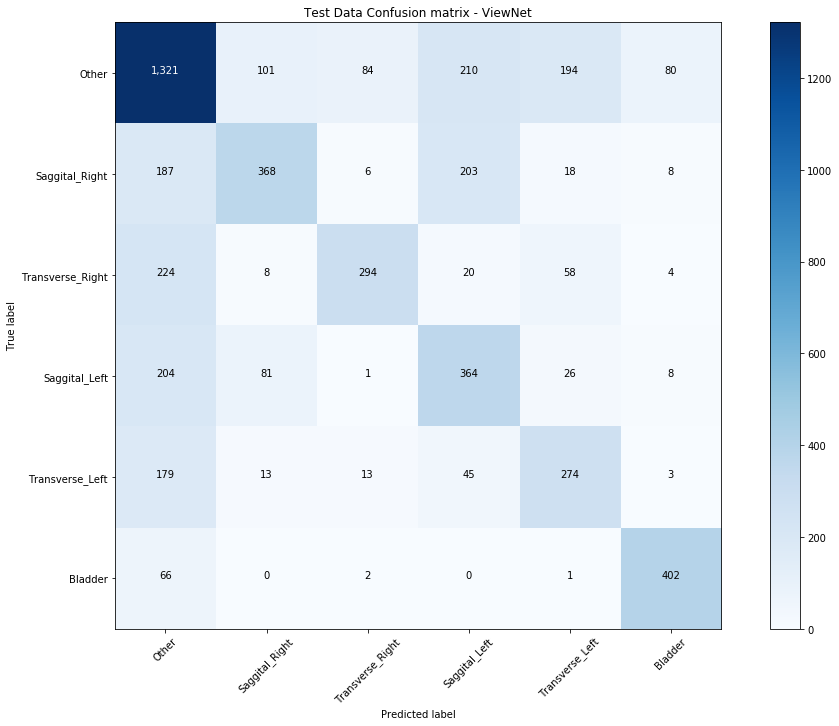

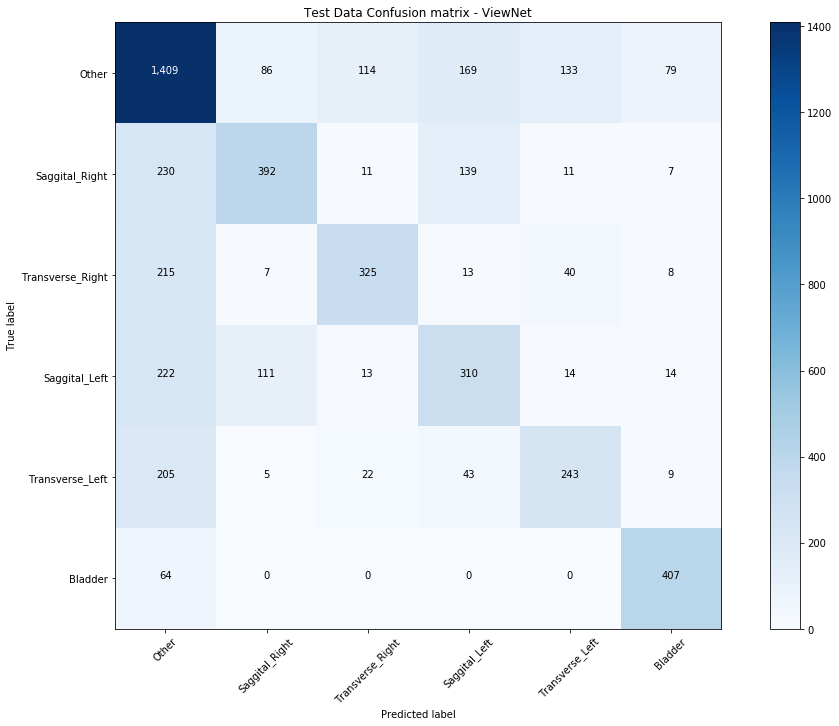

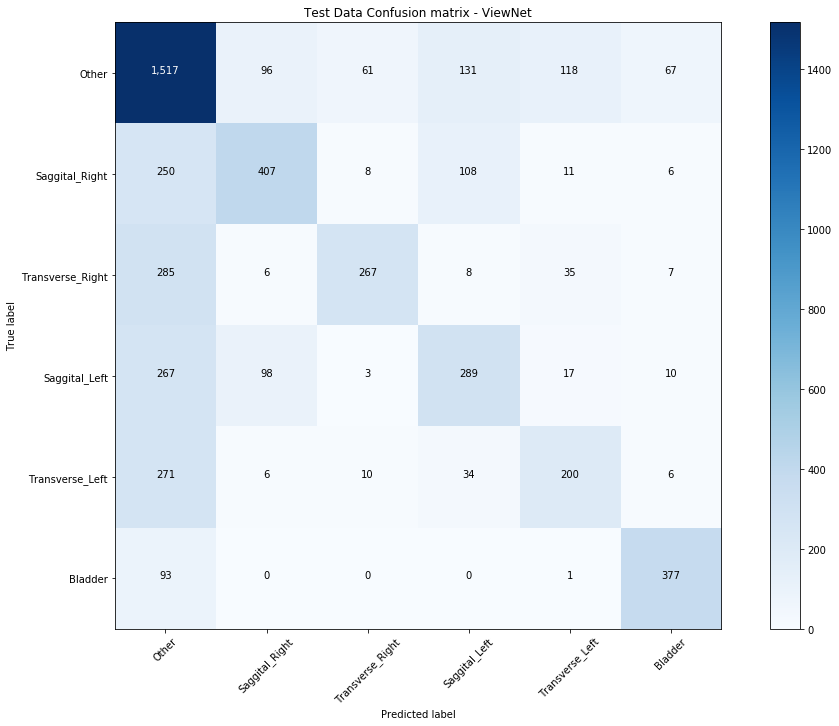

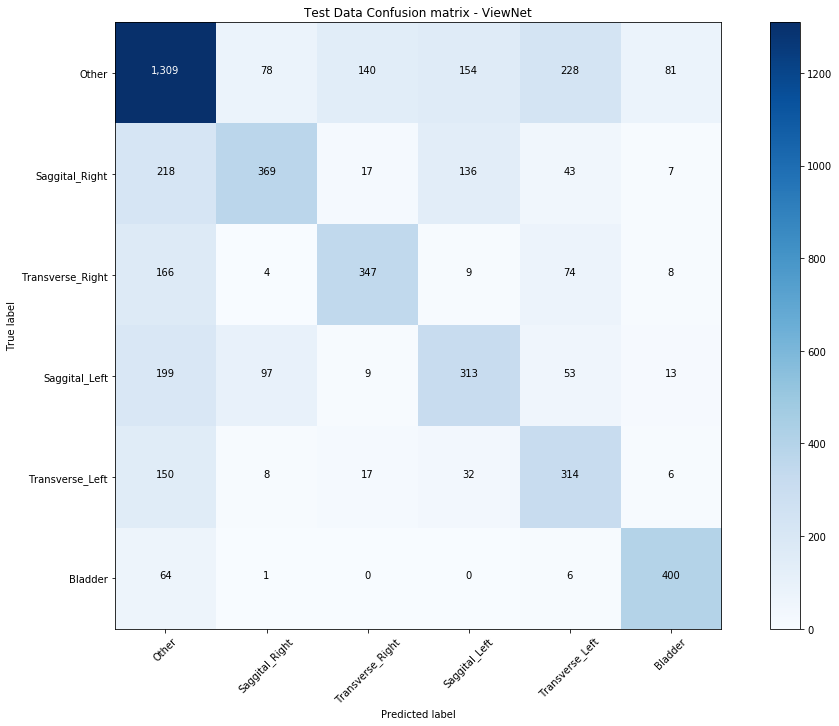

In [16]:
repetitions = 5

conv1_filters = 8
conv2_filters = 16
conv3_filters = 32
linear1_size = 512

dropout = 0.25
lr = 0.0005
wd = 0.001
amsgrad = False

config_string = f"{conv1_filters}_{conv2_filters}_{conv3_filters}_{linear1_size}_{dropout}_{lr}_{wd}_{amsgrad}"
model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
run_configs = {'lr': lr, 'wd': wd, 'amsgrad': amsgrad,'dropout': dropout, 
              'conv1_filters': conv1_filters, 'conv2_filters': conv2_filters, 
              'conv3_filters': conv3_filters, 'linear1_size': linear1_size }

final_df = train5fold(run_configs,criterion_used, model_ft, lr, wd, amsgrad, repetitions)

In [ ]:
final_df.head()